<h2>Improts

In [1]:
#%pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 --index-url https://download.pytorch.org/whl/cu129

In [2]:
import sys
import torch
print(sys.executable)
print("PyTorch Version:", torch.__version__)



C:\Users\Manue\anaconda3\python.exe
PyTorch Version: 2.9.0+cu130


In [3]:
#pip install pandas

In [4]:
import pandas as pd
import json

In [5]:
#GT = Ground Truth
df = pd.DataFrame(columns=['ID', 'GT-Caption', 'CLIP-GT-Score','Modified-Caption','CLIP-Modified-Caption','BLIP-Caption','CLIP-BLIB-Score'])
print(df)

Empty DataFrame
Columns: [ID, GT-Caption, CLIP-GT-Score, Modified-Caption, CLIP-Modified-Caption, BLIP-Caption, CLIP-BLIB-Score]
Index: []


In [6]:
# Datei einlesen
with open("annotations\captions_val2017.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [7]:
df = pd.DataFrame(
    [
        {
            'ID': ann['image_id'],
            'GT-Caption': ann['caption'],
            'CLIP-GT-Score': None,
            'Modified-Caption': None,
            'CLIP-Modified-Caption': None,
            'BLIP-Caption': None,
            'CLIP-BLIB-Score': None
        }
        for ann in data["annotations"]
    ]
)

In [8]:
df.count()

ID                       25014
GT-Caption               25014
CLIP-GT-Score                0
Modified-Caption             0
CLIP-Modified-Caption        0
BLIP-Caption                 0
CLIP-BLIB-Score              0
dtype: int64

In [9]:
df.head()

,ID,GT-Caption,CLIP-GT-Score,Modified-Caption,CLIP-Modified-Caption,BLIP-Caption,CLIP-BLIB-Score
0,179765,A black Honda motorcycle parked in front of a ...,None,None,None,None,None
1,179765,A Honda motorcycle parked in a grass driveway,None,None,None,None,None
2,190236,An office cubicle with four different types of...,None,None,None,None,None
3,331352,A small closed toilet in a cramped space.,None,None,None,None,None
4,517069,Two women waiting at a bench next to a street.,None,None,None,None,None


<h2>Attribute festlegen

In [10]:
attribute_words = [
    # Farben
    "red", "blue", "green", "yellow", "white", "black", "brown", "gray", "orange", "pink",
    # Texturen / Materialien
    "smooth", "rough", "shiny", "matte", "wet", "dry", "wooden", "metallic", "plastic",
    # Wetter / Umgebung
    "snowy", "rainy", "cloudy", "sunny", "foggy", "windy",
    # Formen / Zustände
    "round", "square", "rectangular", "triangular", "flat"
]


In [11]:
attribute_words = [
    "red", "blue", "green", "black", "brown", "gray", "white", "yellow"  # Farben
]


In [12]:
import re

# Regex-Muster aus der Liste bauen, z. B. "(blue|yellow|snowy|...)"
pattern = r'\b(' + '|'.join(attribute_words) + r')\b'

# Filtern — ignoriert Groß-/Kleinschreibung, behandelt NaN sicher
df = df[df['GT-Caption'].str.contains(pattern, flags=re.IGNORECASE, na=False)]

print(len(df), "Zeilen gefunden")
df.head()


3818 Zeilen gefunden


C:\Users\Manue\AppData\Local\Temp\ipykernel_11992\1693752730.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[df['GT-Caption'].str.contains(pattern, flags=re.IGNORECASE, na=False)]


,ID,GT-Caption,CLIP-GT-Score,Modified-Caption,CLIP-Modified-Caption,BLIP-Caption,CLIP-BLIB-Score
0,179765,A black Honda motorcycle parked in front of a ...,None,None,None,None,None
5,179765,A black Honda motorcycle with a dark burgundy ...,None,None,None,None,None
21,109976,An all white kitchen with an electric stovetop.,None,None,None,None,None
24,331352,Off white toilet with a faucet and controls.,None,None,None,None,None
25,109976,A white stove sits between two small counter t...,None,None,None,None,None


<h2>Import Clip</h2>

In [13]:
#%pip uninstall torchvision==0.20.1
#%pip install torchvision==0.23.0

In [14]:
#%conda remove -y pytorch torchvision torchaudio pytorch-cuda cudatoolkit

In [15]:
print(torch.__version__)

2.9.0+cu130


<h2>Zum Testen Kürzen (TMP)

In [16]:
df = df.head(1000)
df.head()

,ID,GT-Caption,CLIP-GT-Score,Modified-Caption,CLIP-Modified-Caption,BLIP-Caption,CLIP-BLIB-Score
0,179765,A black Honda motorcycle parked in front of a ...,None,None,None,None,None
5,179765,A black Honda motorcycle with a dark burgundy ...,None,None,None,None,None
21,109976,An all white kitchen with an electric stovetop.,None,None,None,None,None
24,331352,Off white toilet with a faucet and controls.,None,None,None,None,None
25,109976,A white stove sits between two small counter t...,None,None,None,None,None


<h2>GET-Clip Score Methode

<h2>CLIP Score mit SigLIP L/14</h2>

In [17]:
#!pip install transformers pillow torch
#!pip install sentencepiece
#!pip install protobuf
#!pip install ipywidgets
#!pip install tqdm

In [18]:
import torch
from pathlib import Path
from PIL import Image
from transformers import SiglipProcessor, SiglipModel

device = "cuda"  # oder "cuda" falls verfügbar

# SigLIP-Modell laden (Large / Patch14 / 384px)
model_name = "google/siglip-so400m-patch14-384"
siglip_processor = SiglipProcessor.from_pretrained(model_name, use_fast=True)
siglip_model = SiglipModel.from_pretrained(model_name).to(device)
siglip_model.eval()


def get_clip_score_siglip(image_folder: str, image_id: int, caption: str) -> float:
    """
    Berechnet einen SigLIP-Score (ähnlich Cosine-Similarity) zwischen Bild und Text.
    Verwendet google/siglip-so400m-patch14-384.
    """
    image_path = Path(image_folder) / f"{image_id:012d}.jpg"

    # Bild laden (SigLIP erwartet RGB)
    image = Image.open(image_path).convert("RGB")

    # Processor kümmert sich um Resize, Normalize, Tokenization etc.
    inputs = siglip_processor(
        text=[caption],
        images=[image],
        return_tensors="pt",
        padding=True,
    ).to(device)

    with torch.no_grad():
        outputs = siglip_model(**inputs)
        image_embeds = outputs.image_embeds      # Shape: [1, D]
        text_embeds = outputs.text_embeds        # Shape: [1, D]

        # L2-Normalisierung → Cosine-Similarity via Dot-Product
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

        score = (image_embeds * text_embeds).sum(dim=-1).item()

    return score


In [19]:
from tqdm import tqdm
tqdm.pandas()

df["CLIP-GT-Score"] = df.progress_apply(lambda r: get_clip_score_siglip("val2017/val2017", r["ID"], r["GT-Caption"]), axis=1)
df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:07<00:00,  7.86it/s]


,ID,GT-Caption,CLIP-GT-Score,Modified-Caption,CLIP-Modified-Caption,BLIP-Caption,CLIP-BLIB-Score
0,179765,A black Honda motorcycle parked in front of a ...,0.117255,None,None,None,None
5,179765,A black Honda motorcycle with a dark burgundy ...,0.128438,None,None,None,None
21,109976,An all white kitchen with an electric stovetop.,0.108900,None,None,None,None
24,331352,Off white toilet with a faucet and controls.,0.137742,None,None,None,None
25,109976,A white stove sits between two small counter t...,0.098370,None,None,None,None


<h2>Modified-Caption erzeugen

In [20]:
import random

# Listen automatisch aus Gesamtmenge erzeugen
colors      = attribute_words[0:8]

categories = [colors]

def modify_attribute_word(caption):
    words = caption.split()
    for i, w in enumerate(words):
        lw = w.lower().strip(".,")
        for cat in categories:
            if lw in cat:
                new_word = random.choice([x for x in cat if x != lw])
                # Ersetze das Wort (achte auf Satzzeichen)
                modified = caption.replace(w, new_word, 1)
                return lw, new_word, modified
    return None, None, caption

In [21]:
caption = "A blue shiny car on a sunny day."
orig, new, modified = modify_attribute_word(caption)
print("Originalwort:", orig)
print("Neues Wort:", new)
print("Modifizierte Caption:", modified)


Originalwort: blue
Neues Wort: gray
Modifizierte Caption: A gray shiny car on a sunny day.


In [22]:
# Auf df anwenden: erzeugt input-attribute, output-attribute und Modified-Caption
df[["input-attribute","output-attribute","Modified-Caption"]] = (
    df["GT-Caption"].progress_apply(lambda c: pd.Series(modify_attribute_word(c)))
)

# Optional ansehen
df.head()

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4007.66it/s]


,ID,GT-Caption,CLIP-GT-Score,Modified-Caption,CLIP-Modified-Caption,BLIP-Caption,CLIP-BLIB-Score,input-attribute,output-attribute
0,179765,A black Honda motorcycle parked in front of a ...,0.117255,A blue Honda motorcycle parked in front of a g...,None,None,None,black,blue
5,179765,A black Honda motorcycle with a dark burgundy ...,0.128438,A yellow Honda motorcycle with a dark burgundy...,None,None,None,black,yellow
21,109976,An all white kitchen with an electric stovetop.,0.108900,An all brown kitchen with an electric stovetop.,None,None,None,white,brown
24,331352,Off white toilet with a faucet and controls.,0.137742,Off brown toilet with a faucet and controls.,None,None,None,white,brown
25,109976,A white stove sits between two small counter t...,0.098370,A red stove sits between two small counter tops.,None,None,None,white,red


In [23]:
df["CLIP-Modified-Caption"] = df.progress_apply(lambda r: get_clip_score_siglip("val2017/val2017", r["ID"], r["Modified-Caption"]), axis=1)
df.head()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:08<00:00,  7.80it/s]


,ID,GT-Caption,CLIP-GT-Score,Modified-Caption,CLIP-Modified-Caption,BLIP-Caption,CLIP-BLIB-Score,input-attribute,output-attribute
0,179765,A black Honda motorcycle parked in front of a ...,0.117255,A blue Honda motorcycle parked in front of a g...,0.071858,None,None,black,blue
5,179765,A black Honda motorcycle with a dark burgundy ...,0.128438,A yellow Honda motorcycle with a dark burgundy...,0.109097,None,None,black,yellow
21,109976,An all white kitchen with an electric stovetop.,0.108900,An all brown kitchen with an electric stovetop.,0.096085,None,None,white,brown
24,331352,Off white toilet with a faucet and controls.,0.137742,Off brown toilet with a faucet and controls.,0.120425,None,None,white,brown
25,109976,A white stove sits between two small counter t...,0.098370,A red stove sits between two small counter tops.,0.079540,None,None,white,red


<h2> GET BLIP Caption Funktion

In [24]:
#pip install --upgrade torch --index-url https://download.pytorch.org/whl/cu121

In [25]:
from pathlib import Path
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration

blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base",use_fast=True)
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

def get_blip_caption(image_folder: str, image_id: int) -> str:
    image_path = Path(image_folder) / f"{image_id:012d}.jpg"
    image = Image.open(image_path).convert("RGB")
    inputs = blip_processor(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        out = blip_model.generate(**inputs, max_new_tokens=30)
    return blip_processor.decode(out[0], skip_special_tokens=True)


In [26]:
df["BLIP-Caption"] = df["ID"].progress_apply(lambda img_id: get_blip_caption("val2017/val2017", img_id))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:14<00:00,  1.48it/s]


In [27]:
df.head()

,ID,GT-Caption,CLIP-GT-Score,Modified-Caption,CLIP-Modified-Caption,BLIP-Caption,CLIP-BLIB-Score,input-attribute,output-attribute
0,179765,A black Honda motorcycle parked in front of a ...,0.117255,A blue Honda motorcycle parked in front of a g...,0.071858,a motorcycle parked in the grass outside,None,black,blue
5,179765,A black Honda motorcycle with a dark burgundy ...,0.128438,A yellow Honda motorcycle with a dark burgundy...,0.109097,a motorcycle parked in the grass outside,None,black,yellow
21,109976,An all white kitchen with an electric stovetop.,0.108900,An all brown kitchen with an electric stovetop.,0.096085,a kitchen with a stove and microwave,None,white,brown
24,331352,Off white toilet with a faucet and controls.,0.137742,Off brown toilet with a faucet and controls.,0.120425,a toilet with a tank and a tankless toilet,None,white,brown
25,109976,A white stove sits between two small counter t...,0.098370,A red stove sits between two small counter tops.,0.079540,a kitchen with a stove and microwave,None,white,red


In [28]:
from tqdm.notebook import tqdm
tqdm.pandas()

df["CLIP-BLIB-Score"] = df.progress_apply(lambda r: get_clip_score_siglip("val2017/val2017", r["ID"], r["BLIP-Caption"]), axis=1)
df.head()

  0%|          | 0/1000 [00:00<?, ?it/s]

,ID,GT-Caption,CLIP-GT-Score,Modified-Caption,CLIP-Modified-Caption,BLIP-Caption,CLIP-BLIB-Score,input-attribute,output-attribute
0,179765,A black Honda motorcycle parked in front of a ...,0.117255,A blue Honda motorcycle parked in front of a g...,0.071858,a motorcycle parked in the grass outside,0.093985,black,blue
5,179765,A black Honda motorcycle with a dark burgundy ...,0.128438,A yellow Honda motorcycle with a dark burgundy...,0.109097,a motorcycle parked in the grass outside,0.093985,black,yellow
21,109976,An all white kitchen with an electric stovetop.,0.108900,An all brown kitchen with an electric stovetop.,0.096085,a kitchen with a stove and microwave,0.112075,white,brown
24,331352,Off white toilet with a faucet and controls.,0.137742,Off brown toilet with a faucet and controls.,0.120425,a toilet with a tank and a tankless toilet,0.132474,white,brown
25,109976,A white stove sits between two small counter t...,0.098370,A red stove sits between two small counter tops.,0.079540,a kitchen with a stove and microwave,0.112075,white,red


In [29]:
df.to_pickle("data2.pkl")

In [30]:
df.to_csv("data2.csv", index=False)

In [31]:
#df = pd.read_pickle("mein_dataframe5.pkl")

In [32]:
df.head()

,ID,GT-Caption,CLIP-GT-Score,Modified-Caption,CLIP-Modified-Caption,BLIP-Caption,CLIP-BLIB-Score,input-attribute,output-attribute
0,179765,A black Honda motorcycle parked in front of a ...,0.117255,A blue Honda motorcycle parked in front of a g...,0.071858,a motorcycle parked in the grass outside,0.093985,black,blue
5,179765,A black Honda motorcycle with a dark burgundy ...,0.128438,A yellow Honda motorcycle with a dark burgundy...,0.109097,a motorcycle parked in the grass outside,0.093985,black,yellow
21,109976,An all white kitchen with an electric stovetop.,0.108900,An all brown kitchen with an electric stovetop.,0.096085,a kitchen with a stove and microwave,0.112075,white,brown
24,331352,Off white toilet with a faucet and controls.,0.137742,Off brown toilet with a faucet and controls.,0.120425,a toilet with a tank and a tankless toilet,0.132474,white,brown
25,109976,A white stove sits between two small counter t...,0.098370,A red stove sits between two small counter tops.,0.079540,a kitchen with a stove and microwave,0.112075,white,red


<h2>Boxplots von ΔCLIP pro Attributgruppe (zeigt Unterschiede der Sensitivität)

<Figure size 1000x600 with 0 Axes>

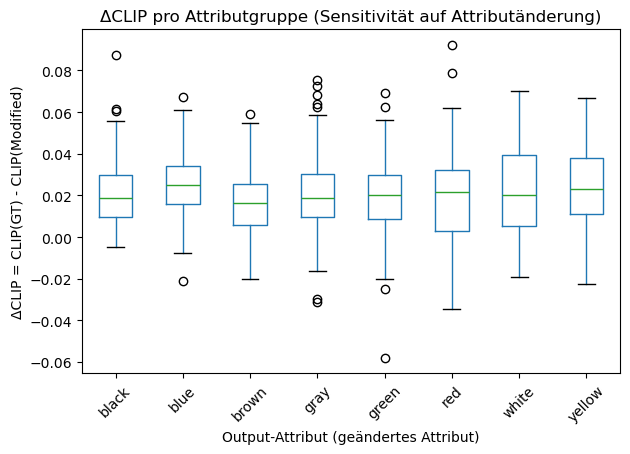

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# ΔCLIP berechnen (Sensitivität des Modells gegenüber der Attributänderung)
df['delta_clip'] = df['CLIP-GT-Score'] - df['CLIP-Modified-Caption']

# Boxplot nach Attributgruppen
plt.figure(figsize=(10, 6))
df.boxplot(column='delta_clip', by='output-attribute', grid=False)

# Styling
plt.title("ΔCLIP pro Attributgruppe (Sensitivität auf Attributänderung)")
plt.suptitle("")  # entfernt den automatischen übergeordneten Titel
plt.xlabel("Output-Attribut (geändertes Attribut)")
plt.ylabel("ΔCLIP = CLIP(GT) - CLIP(Modified)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


🧠 Bedeutung der Achsen

x-Achse: Das geänderte Attribut (z. B. „blue“, „brown“, „red“ usw.).

y-Achse: ΔCLIP = CLIP(GT) − CLIP(Modified)
→ Ein Maß für die Sensitivität von CLIP gegenüber der Attributänderung.

📊 Interpretation der Werte





Positive ΔCLIP-Werte (über 0):
→ CLIP bewertet die Ground Truth Caption (mit dem richtigen Attribut) höher als die manipulierte Caption.
→ CLIP erkennt also die Attributänderung korrekt.

ΔCLIP nahe 0 oder negativ:
→ CLIP bewertet die manipulierte Caption gleich oder sogar höher als die echte.
→ Geringe Sensitivität – CLIP „merkt“ die falsche Beschreibung kaum oder bevorzugt sie sogar.

🔍 Beobachtungen aus dem Plot

Hohe Sensitivität:

pink, red, blue, white, black haben im Mittel positive ΔCLIP-Werte mit klarer Streuung nach oben.
→ CLIP reagiert zuverlässig, wenn diese Farben verändert werden.
→ Besonders „red“ und „pink“ zeigen eine große Differenz – CLIP erkennt Farbänderungen dort sehr gut.

Mittlere Sensitivität:

orange, yellow, brown, gray liegen nahe bei 0, mit moderater Streuung.
→ CLIP ist hier unsicher – diese Farbänderungen sind visuell subtil oder kontextabhängig.

Geringe oder inkonsistente Sensitivität:

green und rough haben teilweise negative ΔCLIP-Werte.
→ CLIP bewertet die veränderte Caption teils besser als die wahre → Fehlurteile.
→ „green“ ist visuell schwierig (oft viele Grüntöne in Bildern), daher wahrscheinlich eine systematische Schwäche.

Kleine Boxen (z. B. metallic, round, sunny):
→ Zu wenige Datenpunkte (niedrige Varianz). Diese Kategorien sind im Datensatz wahrscheinlich selten.

📈 Fazit

CLIP unterscheidet starke Farbkontraste (black, red, blue) zuverlässig.

Bei verwandten Farben (gray, brown, yellow) oder nichtfarblichen Attributen (rough, round) reagiert CLIP unsicher oder fehlerhaft.

Insgesamt deutet das darauf hin, dass CLIP’s visuelle Semantik für Farbe robust ist, aber feinere oder abstraktere Attribute weniger gut erfasst werden.

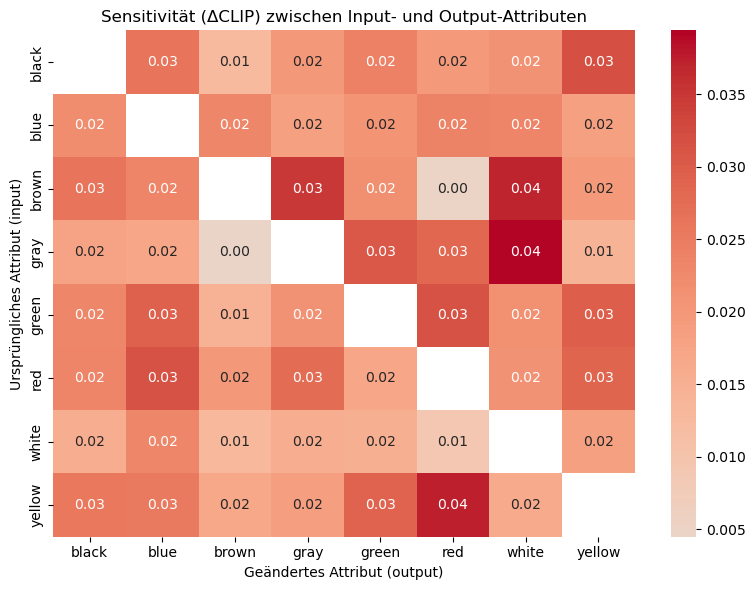

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ΔCLIP berechnen (Sensitivität pro Beispiel)
df["delta_clip"] = df["CLIP-GT-Score"] - df["CLIP-Modified-Caption"]

# Pivot-Tabelle: Mittelwert von ΔCLIP für jede (input, output)-Kombination
pivot = df.pivot_table(
    values="delta_clip",
    index="input-attribute",
    columns="output-attribute",
    aggfunc="mean"
)

# Heatmap plotten
plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", center=0)

plt.title("Sensitivität (ΔCLIP) zwischen Input- und Output-Attributen")
plt.xlabel("Geändertes Attribut (output)")
plt.ylabel("Ursprüngliches Attribut (input)")
plt.tight_layout()
plt.show()


🧭 Was dargestellt wird

x-Achse: das geänderte Attribut (output-attribute)

y-Achse: das ursprüngliche Attribut (input-attribute)

Farbskala: mittlerer ΔCLIP-Wert

🔴 rote Felder → positive ΔCLIP → CLIP erkennt die Änderung deutlich (hohe Sensitivität)

🔵 blaue Felder → negative ΔCLIP → CLIP bewertet die manipulierte Caption teils besser → Fehlbewertung

🤍 helle Felder → kaum Unterschied → geringe Sensitivität

📊 Interpretation der beobachteten Muster

Stärkste Reaktionen (hohe Sensitivität):

Besonders green → red (Δ≈0.05) sticht heraus → CLIP erkennt diesen Farbkontrast sehr gut.
→ Große semantische und visuelle Differenz.

Auch black → blue, red → black, flat → red und green → white zeigen moderate positive Werte (~0.02–0.03).
→ Farblich kontrastreiche Änderungen führen zu deutlichen Score-Unterschieden.

Geringe oder inkonsistente Reaktionen:

Bei vielen Farbsubstitutionen wie blue → brown, white → gray, yellow → blue liegt ΔCLIP nahe 0.
→ CLIP reagiert kaum – diese Farben sind visuell ähnlich oder schwer abzugrenzen.

Besonders black → green (-0.04) ist auffällig negativ: CLIP bewertet die falsche Caption mit „green“ teilweise höher als die richtige – Fehlinterpretation.

Kaum Reaktion bei textuellen oder abstrakten Attributen:

„cloudy“, „dry“, „flat“, „round“, „sunny“ liegen meist bei 0 → CLIP ist farbsensitiv, aber schwach bei semantischen/abstrakten Attributen.

Das deutet auf eine visuell dominierte Repräsentation hin, die kaum konzeptuelle Attribute (z. B. Wetter, Form) erfasst.

Symmetrie:

Die Matrix ist nicht symmetrisch, d. h. „black→blue“ ≠ „blue→black“.
→ CLIP reagiert unterschiedlich je nach Richtung der Änderung.
Beispiel: „black→blue“ wird besser erkannt als „blue→black“. Das deutet auf Frequenzeffekte oder Trainingsbias hin – CLIP hat manche Farbzuordnungen häufiger gelernt.

🧠 Fazit

CLIP ist am stärksten bei deutlichen Farbkontrasten (green↔red, black↔bright colors).

Ähnliche Farben oder subtile Unterschiede (gray, brown, yellow, white) werden oft übersehen.

Abstrakte Attribute (round, dry, cloudy) zeigen nahezu keine Sensitivität – CLIP ist dafür kaum trainiert.

Leichte Richtungsasymmetrien deuten auf Bias im Trainingsdatensatz hin (z. B. mehr schwarze als grüne Objekte in typischen Kontexten).

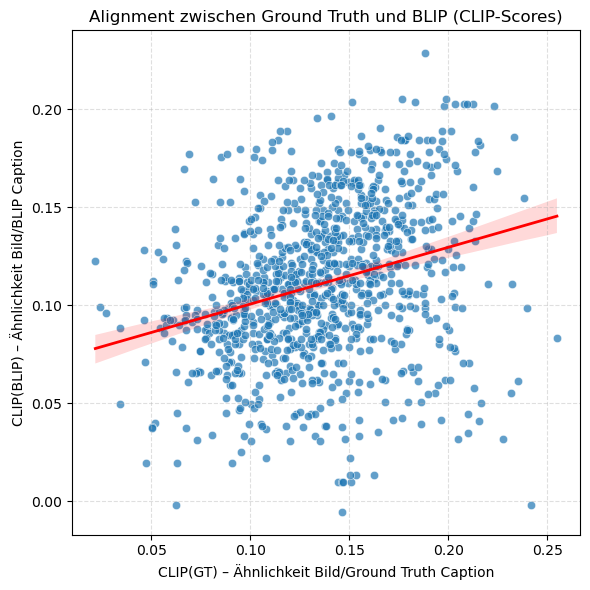

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))
sns.scatterplot(data=df, x="CLIP-GT-Score", y="CLIP-BLIB-Score", alpha=0.7)

# Regressionslinie (optional, zeigt Trend)
sns.regplot(data=df, x="CLIP-GT-Score", y="CLIP-BLIB-Score",
            scatter=False, color="red", line_kws={"lw":2})

plt.title("Alignment zwischen Ground Truth und BLIP (CLIP-Scores)")
plt.xlabel("CLIP(GT) – Ähnlichkeit Bild/Ground Truth Caption")
plt.ylabel("CLIP(BLIP) – Ähnlichkeit Bild/BLIP Caption")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
